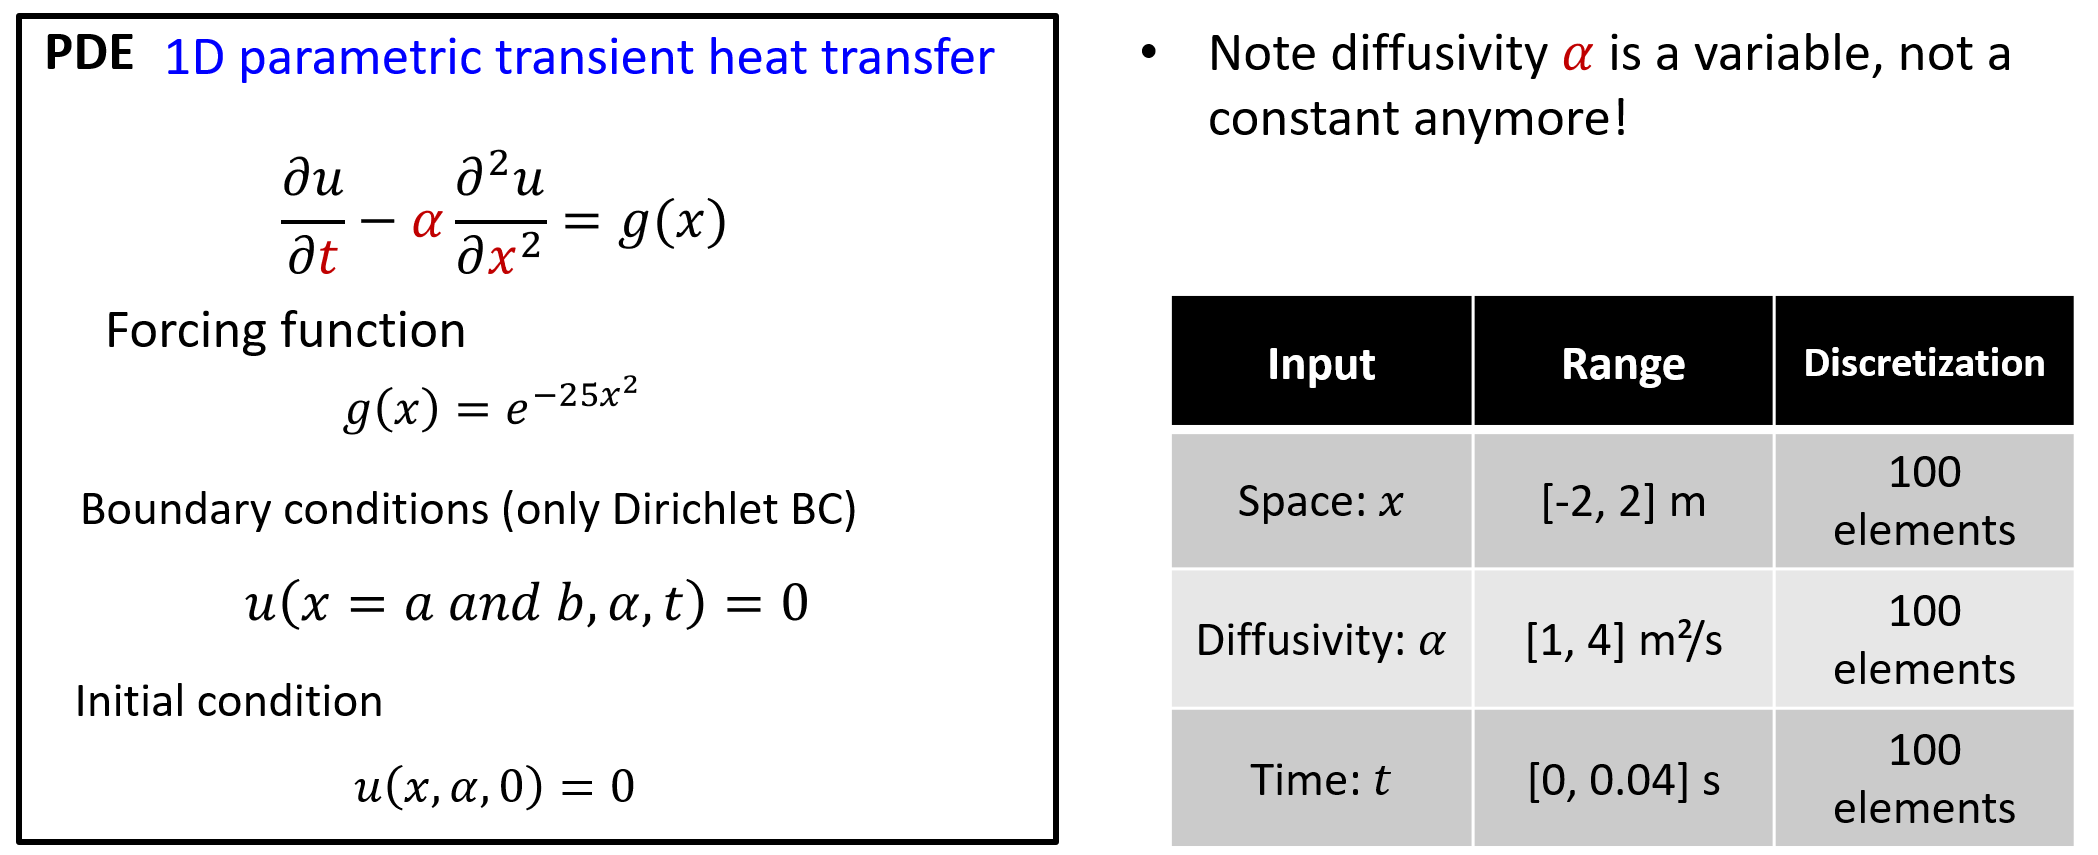

In [ ]:
import numpy as onp
import jax
import jax.numpy as np
import time
import os,sys

currentdir = os.getcwd()
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

from src.CFEM_shape_fun import *
from src.GPU_support import mem_report
from src.generate_mesh import *
from src.CFEM_utilities_STP_sparse import *


jax.config.update("jax_enable_x64", True)

onp.set_printoptions(threshold=sys.maxsize, linewidth=1000, suppress=True, precision=4)





start_time_org = time.time()


num_mode = 10
num_max_iter = 100

nelem_x = 100 # number of elements in the x direction
nelem_t = 300 # number of elements in the t direction
nelem_a = 200 # number of elements in the y direction

Lx = 4 # length of the domain
Lt = 1 # length of the domain
La = 3 # length of the domain
shift_x = Lx/2

s_patch_x = 2; s_patch_t = 2; s_patch_a = 2 # patch size
p_X = -1; p_T = -1; p_A = -1 # patch size
    
alpha_dil_x = 20; alpha_dil_t = 20; alpha_dil_a = 20 # dilation factor

Gauss_Num_FEM = 2 # 6
Gauss_Num_CFEM = 8

p_dict={0:0, 1:2, 2:3, 3:4} 
mbasis = p_dict[2]  

# uniform body force
@jax.jit
def fun_x(x):
    b = np.exp(-25 * x**2)
    return b

@jax.jit
def fun_a(a):
    return np.ones_like(a)

@jax.jit
def fun_t(t):
    return np.ones_like(t)


fun_x_s = [fun_x]  #
fun_a_s = [fun_a]  #
fun_t_s = [fun_t]  #


elem_type = 'D1LN2N' # 'D1LN2N'
nodes_per_elem = int(elem_type[4:-1]) #same for space and parameter for the same type of elements
dim = int(elem_type[1])
elem_dof = nodes_per_elem*dim    


fun_x_s_vvmap = [jax.jit(jax.vmap(jax.vmap(fun, in_axes = (0)), in_axes = (0))) for fun in fun_x_s]
fun_a_s_vvmap = [jax.jit(jax.vmap(jax.vmap(fun, in_axes = (0)), in_axes = (0))) for fun in fun_a_s]
fun_t_s_vvmap = [jax.jit(jax.vmap(jax.vmap(fun, in_axes = (0)), in_axes = (0))) for fun in fun_t_s]

force_fun_dict = {
    'x':fun_x_s_vvmap,
    'a':fun_a_s_vvmap,
    't':fun_t_s_vvmap
}

## Mesh generation
non_uniform_mesh_bool = False
#XY_host: nodal coord; #Elem_nodes_host: element and its nodal id
x, Elem_nodes_x = uniform_mesh_new(Lx, nelem_x)
t, Elem_nodes_t = uniform_mesh_new(Lt, nelem_t)
a, Elem_nodes_a = uniform_mesh_new(La, nelem_a)

x = x - shift_x
a = a + 1.


## Displacement boundary condition
disp_BCx_idx = onp.array([0, nelem_x], dtype = onp.int32)     # nodal index where the Dirichlet boundary condition is imposed
disp_BCx = onp.array([0., 0.], dtype=np.double) # Dirichlet boundary condition value

IC_idx = onp.array([0], dtype = onp.int32)     # nodal index where the Dirichlet boundary condition is imposed
IC = onp.array([0.], dtype=np.double) # Dirichlet boundary condition value


#####XTD
dof_global_x = nelem_x + 1; dof_global_t = nelem_t + 1; dof_global_a = nelem_a + 1

indices_x, indptr_x = get_adj_mat(Elem_nodes_x, nelem_x+1, s_patch_x)
indices_t, indptr_t = get_adj_mat(Elem_nodes_t, nelem_t+1, s_patch_t)
indices_a, indptr_a = get_adj_mat(Elem_nodes_a, nelem_a+1, s_patch_a)
print(f"CFEM adj_s matrix took {time.time() - start_time_org:.4f} seconds")
# patch settings for X
d_c_x = Lx/nelem_x; d_c_t = Lt/nelem_t; d_c_a = La/nelem_a
a_dil_x = alpha_dil_x * d_c_x; a_dil_t = alpha_dil_t * d_c_t; a_dil_a = alpha_dil_a * d_c_a
start_time = time.time()
edex_max_x, ndex_max_x = get_dex_max(indices_x, indptr_x, s_patch_x, Elem_nodes_x)
edex_max_t, ndex_max_t = get_dex_max(indices_t, indptr_t, s_patch_t, Elem_nodes_t)
edex_max_a, ndex_max_a = get_dex_max(indices_a, indptr_a, s_patch_a, Elem_nodes_a)

input_dict = {
    'coor':{'x':x, 'a': a, 't': t},
    'Elem_nodes':{'x':Elem_nodes_x, 'a': Elem_nodes_a, 't': Elem_nodes_t},
    'indices':{'x':indices_x, 'a': indices_a, 't': indices_t},
    'indptr':{'x':indptr_x, 'a': indptr_a, 't': indptr_t},
    'edex_max':{'x':edex_max_x, 'a': edex_max_a, 't': edex_max_t},
    'ndex_max':{'x':ndex_max_x, 'a': ndex_max_a, 't': ndex_max_t},
    's_patch':{'x':s_patch_x, 'a': s_patch_a, 't': s_patch_t},
    'a_dil':{'x':a_dil_x, 'a': a_dil_a, 't': a_dil_t},    
}

shape_fun_dict = get_CTD_shape_fun_dict(input_dict, mbasis, Gauss_Num_CFEM, elem_type)

N_til_x = shape_fun_dict['x']['N_til']; N_til_a = shape_fun_dict['a']['N_til']; N_til_t = shape_fun_dict['t']['N_til']
Grad_N_til_x = shape_fun_dict['x']['Grad_N_til']; Grad_N_til_a = shape_fun_dict['a']['Grad_N_til']; Grad_N_til_t = shape_fun_dict['t']['Grad_N_til']
JxW_x = shape_fun_dict['x']['JxW']; JxW_a = shape_fun_dict['a']['JxW']; JxW_t = shape_fun_dict['t']['JxW']
Ele_patch_n_x = shape_fun_dict['x']['Elemental_patch_nodes_st']
Ele_patch_n_a = shape_fun_dict['a']['Elemental_patch_nodes_st']
Ele_patch_n_t = shape_fun_dict['t']['Elemental_patch_nodes_st']

(K_Bx_Bx, K_Nx_Nx) = get_matrix_x(x,Elem_nodes_x,N_til_x, Grad_N_til_x, 
                JxW_x, Ele_patch_n_x,
                Gauss_Num_CFEM, elem_type)

(K_Nt_Bt, K_Nt_Nt) = get_matrix_t(t,Elem_nodes_t,N_til_t, Grad_N_til_t,
                JxW_t, Ele_patch_n_t,
                Gauss_Num_CFEM, elem_type)

(K_Na_a_Na, K_Na_Na) = get_matrix_k(a,Elem_nodes_a,N_til_a, Grad_N_til_a,
                JxW_a, Ele_patch_n_a,
                Gauss_Num_CFEM, elem_type)

K_Bx_Bx = bcoo_2_csr(K_Bx_Bx); K_Nx_Nx = bcoo_2_csr(K_Nx_Nx)
K_Na_a_Na = bcoo_2_csr(K_Na_a_Na); K_Na_Na = bcoo_2_csr(K_Na_Na)
K_Nt_Bt = bcoo_2_csr(K_Nt_Bt); K_Nt_Nt = bcoo_2_csr(K_Nt_Nt)

ext_force_dict = get_ext_force_dict(input_dict, shape_fun_dict, force_fun_dict)

Qx_ext = onp.array(ext_force_dict['x'])
Qa_ext = onp.array(ext_force_dict['a'])
Qt_ext = onp.array(ext_force_dict['t'])

## solver

In [ ]:
x = onp.array(x, dtype = np.double)
t = onp.array(t, dtype = np.double)
a = onp.array(a, dtype = np.double)
Qx_ext = Qx_ext.reshape((1, dof_global_x)) # source rank 1
Qa_ext = Qa_ext.reshape((1, dof_global_a)) # source rank 1
Qt_ext = Qt_ext.reshape((1, dof_global_t)) # source rank 1

#Big loop: keep adding modes until convergence
modes = num_mode
U_x = onp.random.rand(modes, dof_global_x)
U_t = onp.random.rand(modes, dof_global_t)
U_a = onp.random.rand(modes, dof_global_a)


variation0 = 1e10
for j in range(num_max_iter):
    U_x, U_t, U_a, variation, norm = \
        TD_solver_STP_1D_sylv(K_Bx_Bx, K_Nx_Nx, K_Na_Na, K_Na_a_Na,  
                  K_Nt_Nt, K_Nt_Bt, 
                  Qx_ext, Qa_ext, Qt_ext,  
                  U_x, U_a, U_t, disp_BCx_idx, IC_idx)
              
    norm_coef = (onp.linalg.norm(U_x) * onp.linalg.norm(U_t) * onp.linalg.norm(U_a))**(1./3)
    U_x = norm_coef * U_x / onp.linalg.norm(U_x)
    U_t = norm_coef * U_t / onp.linalg.norm(U_t)
    U_a = norm_coef * U_a / onp.linalg.norm(U_a)

    print(f"Variation: {variation}, Norm: {norm}")
STP_sol = {}
STP_sol['U_x'] = U_x; STP_sol['U_t'] = U_t; STP_sol['U_a'] = U_a

print(f'{bcolors.HEADER}Finished, costs {time.time() - start_time} {bcolors.ENDC}')


## post-processing

In [ ]:
@jax.jit
def CTD_STP_nodal_visual(U_x, U_t, U_k, id_k, id_t): #u(x) 
    '''
    generate 3d (x,y,z) data for visualization
    dim:(num_ele_x*num_quad, num_ele_y*num_quad, num_ele_z*num_quad)
    
    '''
    num_mode = U_x.shape[0]
        
    #shape_vals: (quad_num, nodes_per_elem)->         (num_mode, quad_num, nelem, nodes_per_elem) 
    ###############################################################################To be modified
    #  N_til_x:  (nelem, quad_num, edex_max_x)  --> ((num_mode), nelem, quad_num, edex_max_x) 
    #  um_nodal: (num_mode, nelem, edex_max_x)  -->  (num_mode,  nelem, (quad_num), edex_max_x)
    
    t_interpolated = U_t[:, id_t] #dim (num_mode)
    k_interpolated = U_k[:, id_k] #dim (num_mode)
    #u_x(num_mode, nelem_x, num_quad_x) * (num_mode) sum along axis 0 
    U = np.sum(U_x[:, :] * t_interpolated[:, None] * \
               k_interpolated[:, None], axis = 0) #dim(num_points_x)
    return U  #dim(num_points_x, num_points_y, num_points_z)

In [ ]:
import matplotlib.pyplot as plt
# Create meshgrid for plotting
X, T = np.meshgrid(x.reshape(-1), t.reshape(-1))

num_levels = 50
# Create a figure with two subplots
fig, axes = plt.subplots(figsize=(6, 4))

U_taps = np.zeros((dof_global_x, dof_global_t))  # Initialize TAPSO prediction array

id_a = 0
a_select = a.reshape(-1)[id_a]
print(f"a value: {a_select}")
for time_step in range(dof_global_t):
    # Perform TAPSO update
    U0 = CTD_STP_nodal_visual(U_x, U_t, U_a, id_a, time_step)
    U_taps = U_taps.at[:, time_step].set(U0)  # Store the TAPSO prediction

contour1 = axes.contourf(X, T, U_taps.T, levels=num_levels,cmap='viridis')
axes.set_title('C-HiDeNN-TD prediction', fontsize=16)
axes.set_xlabel('$x$', fontsize=16)
axes.set_ylabel('$t$', fontsize=16)
axes.tick_params(axis='both', labelsize=16)
cbar1 = fig.colorbar(contour1, ax=axes)
cbar1.ax.tick_params(labelsize=14)


## finite difference solution

In [ ]:
# Select an alpha value to plot (middle of the range)
alpha = a_select
x = x.reshape(-1); t = t.reshape(-1)
dx = x.reshape(-1)[1] - x.reshape(-1)[0]; dt = t.reshape(-1)[1] - t.reshape(-1)[0]
Nx = len(x); Nt = len(t)

u = onp.zeros((Nx, Nt))
# Crank-Nicolson implementation
for n in range(dof_global_t-1):
    # Construct the tridiagonal matrix
    r = alpha * dt / (2 * dx**2)
    main_diag = onp.ones(Nx) * (1 + 2*r)
    off_diag = onp.ones(Nx-1) * (-r)
    
    A = onp.diag(main_diag) + onp.diag(off_diag, k=1) + onp.diag(off_diag, k=-1)
    
    # Apply boundary conditions
    A[0, 0]  = 1
    A[0, 1]  = 0
    A[-1, -1] = 1
    A[-1, -2] = 0
    
    # Construct the right-hand side vector
    b = onp.zeros(Nx)
    for i in range(1, Nx-1):
        b[i] = u[i, n] + r*(u[i+1, n] - 2*u[i, n] + u[i-1, n]) + dt * fun_x(x[i])
        
    # Boundary conditions
    b[0] = 0
    b[-1] = 0
    
    # Solve the system
    u[:, n+1] = onp.linalg.solve(A, b)


In [ ]:
from matplotlib.animation import FuncAnimation
# Initiate the plot
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

line_taps, = ax.plot([], [], label='C-HiDeNN-TD Prediction', linestyle='-', color='blue', linewidth=3)
line_analytical, = ax.plot([], [], label='Finite Difference Solution', color='red', linestyle='--')


ax.set_xlabel('x', fontsize=16)
ax.set_ylabel(r'$u(x,t)$', fontsize=16)
ax.legend(fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
text = ax.text(0.02, 0.85, '', transform=ax.transAxes, fontsize=16)

# Set limits
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(min(np.min(U_taps), np.min(U_taps)), 
            max(np.max(U_taps), np.max(U_taps)))

# Animation update function
def update(frame):
    current_time_step = frame
    line_analytical.set_data(x.reshape(-1), u[:, current_time_step])
    line_taps.set_data(x.reshape(-1), U_taps[:, current_time_step])
    return line_taps, text

# Create animation
anim = FuncAnimation(fig, update, frames=range(onp.array(dof_global_t)), blit=True)

# Save the animation
anim.save('TAPS_1d_SPT.gif', dpi=100, writer='pillow', fps=10)
